# Drug/Chemical Reactome Pathway Exploration

---
Samir Akre - October 2019

In [15]:
import neo4j_functions.driver as neo4j_driver
import pandas as pd
import importlib
import progressbar
import seaborn as sns
import matplotlib.pyplot as plt

## Importing curated lists of drugs and chemicals

In [2]:
chemical_list_df = pd.read_csv('lib/Oxidative Stress Text Mining Targets 4.1 - Summary of Oxidative Stress.csv')
drug_list_df = pd.read_csv('lib/Drug list total 04.05.19   - Overview Drug list.csv')

In [3]:
chemical_list_df.head()

,Biological Events of Oxidative Stress,Molecular and Functional Categories,Molecule/Enzyme/Protein,MeSH Heading,MeSH Supplementary,MeSH tree numbers,Chemical Formula,Examples,Pharm Actions,Tree Numbers,References
0,Initiation of Oxidative 1,Reactive Oxygen Species (ROS),Superoxide (anion radical),Superoxides,NaN,D01.248.497.158.685.750.850; D01.339.431.374.8...,O2-,"Superoxide, Hydrogen Peroxide",Oxidants,"D27.720.642,\nD27.888.569.540",PMID: 25547488
1,2,NaN,Hydrogen Peroxide,Hydrogen Peroxide,NaN,D01.248.497.158.685.750.424; D01.339.431.374.4...,H2O2,NaN,"Anti-Infective Agents, Local",D27.505.954.122.187,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oxidants,"D27.720.642,\nD27.888.569.540",NaN
3,3,NaN,Hydroxyl (radical),Hydroxyl Radical,NaN,D01.339.431.249; D01.248.497.158.459.300; D01....,HO,NaN,Oxidants,"D27.720.642,\nD27.888.569.540",NaN
4,4,NaN,alpha oxygen,None listed,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
drug_list_df.head()

,Drug Category,#,Name,Synonyms,MeSH Descriptor,MeSH tree(s),Common adverse effects,Dosage (freq/amount/time/delivery),Duration (time),Pham Action
0,Anticoagulants,1,heparin,"['Calciparine', 'Eparina', 'heparina', 'Hepari...",heparin,D09.698.373.400,"Thrombocytopenia, Cerebral haemorrhage, Haemog...",1/18U/kg/iv,2 days,"Anticoagulants, \nFibrinolytic Agents"
1,NaN,2,warfarin,"['4-Hydroxy-3-(3-oxo-1-phenylbutyl)coumarin', ...",warfarin,D03.383.663.283.446.520.914\nD03.633.100.150.4...,"Haemorrhage, Haematoma, anaemia, Epistaxis, hy...",1/2-10mg/day/po,As needed,"Anticoagulants, \nRodenticides"
2,Thrombolytics,3,streptokinase,['Streptokinase C precursor'],streptokinase,D08.811.277.656.300.775\nD12.776.124.125.662.537,"blurred vision, confusion, dizziness, fever, s...","1/1,500,000 IU/iv",60min,Fibrinolytic Agents
3,NaN,4,urokinase,"['U-plasminogen activator', 'uPA', 'Urokinase-...",Urokinase-Type Plasminogen Activator,D08.811.277.656.300.760.910\nD08.811.277.656.9...,"bleeding gums, coughing up blood, dizziness, h...","1/4,000,000U/iv",10min,NaN
4,NaN,5,tpa,"['Alteplasa', 'Alteplase (genetical recombinat...",Tissue Plasminogen Activator,D08.811.277.656.300.760.875\nD08.811.277.656.9...,NaN,1/0.9mg/kg/iv,60min,Fibrinolytic Agents


## Looking for reactome ids of drugs in curated list
Looks for the lower case name of the drug from the curated list to match any of the lowercase names a drug in reactome is listed in.  

 - Outputs pandas data frame under variable `drugs_in_reactome`
 - 58/155 drugs found to have counter parts in reactome


In [5]:
importlib.reload(neo4j_driver)
driver = neo4j_driver.driver(uri = "bolt://localhost:7687", user = "neo4j", password = "Akre1234")

### Test to see if I can find any drug in the reactome data set

In [6]:
driver.search_item_in_array(
    array_field="name",
    item='"herceptin"',
    class_type='Drug',
    info_cols = ['displayName', 'stId', 'isInDisease'],
    verbose=True
)

Query: 
 MATCH (a:Drug) WHERE toLower("herceptin") IN [x in a.name | toLower(x)] RETURN a.displayName, a.stId, a.isInDisease 


,displayName,stId,isInDisease
0,trastuzumab [extracellular region],R-ALL-9634466,True


### Querying to find reactome ID for each drug in curated list

In [7]:
drugs_in_reactome = pd.DataFrame()
for drug_name in drug_list_df.Name.unique():
    result = driver.search_item_in_array(
        array_field="name",
        item='"%s"' % drug_name,
        class_type='Drug',
        info_cols = ['displayName', 'stId', 'isInDisease']
    )
    result['Name'] = drug_name
    drugs_in_reactome = drugs_in_reactome.append(result)
drugs_in_reactome.head()

,displayName,stId,isInDisease,Name
0,warfarin [cytosol],R-ALL-9014945,True,warfarin
0,dabigatran [extracellular region],R-ALL-9015346,True,dabigatran
0,rivaroxaban [extracellular region],R-ALL-9015055,True,rivaroxaban
0,apixaban [extracellular region],R-ALL-9038732,True,apixaban
0,edoxaban [extracellular region],R-ALL-9038742,True,edoxaban


In [8]:
print('Initial Drug List Size: ', drug_list_df.Name.nunique())
print('Drugs found in Reacome: ', drugs_in_reactome.Name.nunique())


Initial Drug List Size:  155
Drugs found in Reacome:  58


## Looking for pathways associated with each drug found in the Reactome database

- Looks for 25 "nearest" pathways marked as `Pathways` to any drug within 1-3 nodes
- Outputs to `pathways` variable as a pandas dataframe

In [23]:

# Re-initializing driver to account for changes made to driver function
importlib.reload(neo4j_driver)
driver = neo4j_driver.driver(uri = "bolt://localhost:7687", user = "neo4j", password = "Akre1234")

# For each reactome drug ID, looks for 100 "closest" pathways within 1-2 nodes 
pathways = pd.DataFrame()
for reactome_id, d_df, in progressbar.progressbar(drugs_in_reactome.groupby('stId')):
    result = driver.get_n_relations(
        class_1='Drug',
        id_1="'%s'" % reactome_id,
        id_class='stId',
#        class_2='TopLevelPathway',
        class_2='Pathway',
        info_cols=['a.displayName', 'b.displayName', 'b.speciesName'],
        edge_type='*1..2',
        where_clause=" WHERE b.speciesName = 'Homo sapiens'",
        verbose=False,
        n=10000,
    ).rename(columns={
        'a.displayName': 'Drug',
        'b.displayName': 'Pathway',
        'b.speciesName': 'Species'
    })
    pathways = pathways.append(result, ignore_index=True)

pathways.head()

100% (58 of 58) |########################| Elapsed Time: 0:00:16 Time:  0:00:16


,Drug,Pathway,Species,edgeLength
0,warfarin [cytosol],Chaperone Mediated Autophagy,Homo sapiens,2.0
1,warfarin [cytosol],Pink/Parkin Mediated Mitophagy,Homo sapiens,2.0
2,warfarin [cytosol],Receptor Mediated Mitophagy,Homo sapiens,2.0
3,warfarin [cytosol],Microautophagy,Homo sapiens,2.0
4,warfarin [cytosol],Amplification of signal from unattached kine...,Homo sapiens,2.0


In [50]:
pathways['drug'] = pathways['Drug'].str.split(' ').str.get(0)

In [57]:
# Number of drugs per pathway, seperated by edgelength
drugs_per_pathway = pd.DataFrame(pathways.groupby(['Pathway', 'edgeLength']).drug.nunique()).reset_index().sort_values(by=['edgeLength', 'drug'], ascending=[True, False])
drugs_per_pathway.head(n=10)

,Pathway,edgeLength,drug
57,"BMAL1:CLOCK,NPAS2 activates circadian gene exp...",2.0,58
112,Detoxification of Reactive Oxygen Species,2.0,58
189,"Incretin synthesis, secretion, and inactivation",2.0,58
194,Insulin processing,2.0,58
267,Peptide hormone metabolism,2.0,58
304,Regulation of insulin secretion,2.0,58
365,"Synthesis, secretion, and deacylation of Ghrelin",2.0,58
366,"Synthesis, secretion, and inactivation of Gluc...",2.0,58
367,"Synthesis, secretion, and inactivation of Gluc...",2.0,58
7,ATP sensitive Potassium channels,2.0,52


In [53]:
# Number of pathways per drug, seperated by edgeLength
pathways_per_drug = pd.DataFrame(pathways.groupby(['drug', 'edgeLength']).Pathway.nunique()).reset_index().sort_values(by=['edgeLength', 'Pathway'], ascending=[True, False])
pathways_per_drug.head(n=10)

,drug,edgeLength,Pathway
19,enoximone,2.0,389
34,milrinone,2.0,389
57,warfarin,2.0,389
6,betaxolol,2.0,109
0,R-138727,2.0,108
1,acebutolol,2.0,108
2,amlodipine,2.0,108
3,apixaban,2.0,108
4,atenolol,2.0,108
7,candesartan,2.0,108


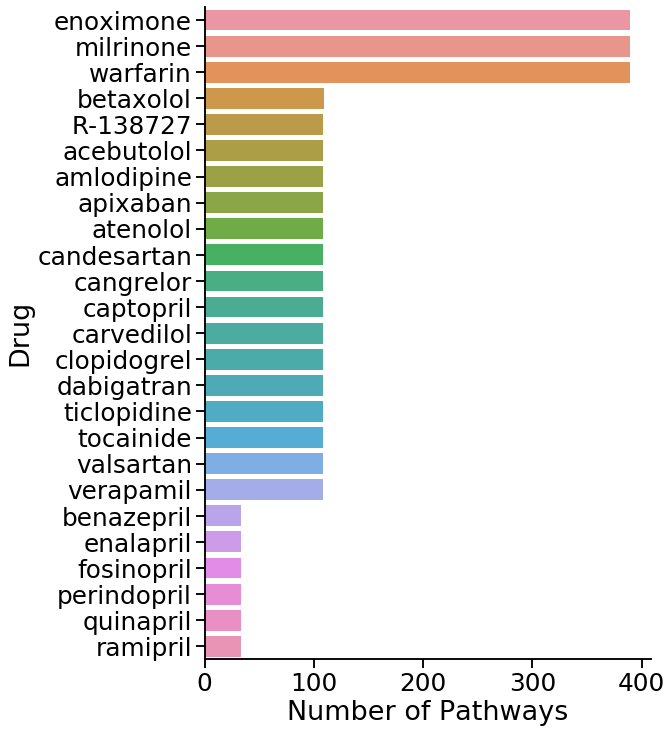

In [56]:
# Plotting top 15 and bottom 10 drugs
sns.set_context('talk', font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 12))
sns.countplot(
    y='drug',
    order=pd.concat([pathways_per_drug.head(15), pathways_per_drug.tail(10)]).drug,
    data=pathways,
    ax=ax
)
ax.set_xlabel('Number of Pathways')
ax.set_ylabel('Drug')

sns.despine()

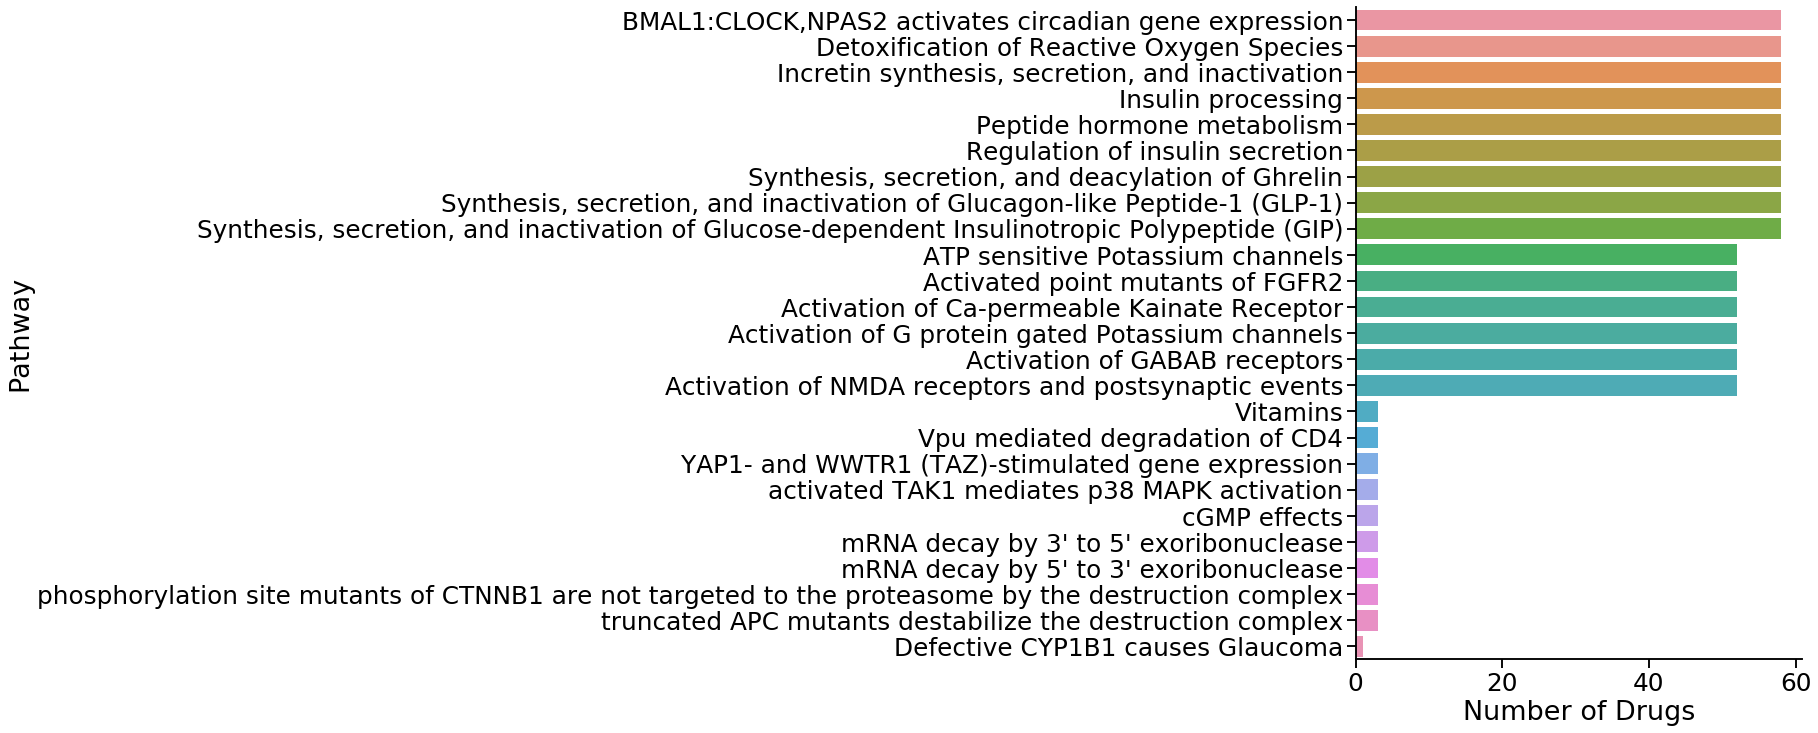

In [59]:
# Plotting top 15 and bottom 10 pathways

sns.set_context('talk', font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 12))
sns.countplot(
    y='Pathway',
    order=pd.concat([drugs_per_pathway.head(15), drugs_per_pathway.tail(10)]).Pathway,
    data=pathways,
    ax=ax
)
ax.set_xlabel('Number of Drugs')
ax.set_ylabel('Pathway')

sns.despine()

## Test Cypher Queries in custom neo4j driver implementation

In [59]:
driver.get_node_info(
    id_field="stId",
    id_val="R-ALL-9634956",
    class_type='Drug',
    info_cols = ['displayName', 'name', 'isInDisease']
)

Query: 
 MATCH (a:Drug {stId: $idnum}) RETURN a.displayName, a.name, a.isInDisease 
pyridostigmine [extracellular region]
['pyridostigmine']
True


,displayName,name,isInDisease
0,pyridostigmine [extracellular region],[pyridostigmine],True


In [131]:
driver.get_n_nodes_info(
    class_type='Drug',
    info_cols = ['displayName', 'name', 'isInDisease'],
    n=10
)

Query: 
 MATCH (a:Drug) RETURN a.displayName, a.name, a.isInDisease LIMIT 10


,displayName,name,isInDisease
0,trastuzumab [extracellular region],"[trastuzumab, herceptin, D5v8, R-597]",True
0,CP-724714 [cytosol],[CP-724714],True
0,Afatinib [cytosol],"[Afatinib, BIBW2992, Irreversible TKI inhibito...",True
0,AZ5104 [cytosol],[AZ5104],True
0,Sapitinib [cytosol],[Sapitinib],True
0,Tesevatinib [cytosol],"[Tesevatinib, EXEL-7647, XL-647, KD-019, XL647]",True
0,Lapatinib [cytosol],"[Lapatinib, GW572016, Tykerb, Reversible tyros...",True
0,Neratinib [cytosol],"[Neratinib, HKI-272, afatinib, Irreversible ty...",True
0,AEE788 [cytosol],[AEE788],True
0,Canertinib [cytosol],"[Canertinib, CI-1033, Irreversible TKI inhibit...",True
